# Install essential python packages

In [1]:
!pip install -q timm albumentations #wandb
!pip install catalyst
!pip install tqdm

# Import essential python packages

In [128]:
from glob import glob
from sklearn.model_selection import GroupKFold
import torch
from torch import nn
import torch.nn.functional as F
import os
import time
from datetime import datetime
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SequentialSampler
import wandb
import timm
import shutil
from catalyst.data.sampler import BalanceClassSampler
import warnings
from tqdm import tqdm

warnings.filterwarnings(action='ignore')

# Hyper-parameter setting

In [129]:
args = {
    'model_name': 'tf_efficientnet_b0_ns',  # 신경망 구조
    'lr': 1e-3,  # 학습률
    'weight_decay': 1e-4,  # 가중치 감쇠
    'drop_rate': 0.2,  # 학습 시 dropout 비율
    'image_size': 256,  # 이미지 크기
    'num_epochs': 10,  # 학습 반복수
    'batch_size': 64,  # 미니배치 크기
    'num_classes': 2,  # 판별할 클래스 개수
    'num_folds': 10,  # 데이터셋 분할 fold 개수
    'val_fold': 0,  # 검증용 fold 선택
    'seed': 42,  # 랜덤 seed 설정
    'log_step': 50,  # log 남길 iteration 반복 수
    'model_save_step': 5,  # model 저장할 epoch 반복 수
    'workspace_path': '//kaggle/input/image-anomaly-detection',  # 작업 위치
    'checkpoint_dir': './checkpoints',  # 모델 저장 디렉토리
    'pretrained_name': 'tf_efficientnet_b0_ns_model_best.pth',  # 학습한 모델 파일이름 (.pth까지 붙이기)
}

TRAIN_DATA_ROOT_PATH = os.path.join(args['workspace_path'], 'train')
TEST_DATA_ROOT_PATH = os.path.join(args['workspace_path'], 'test')

In [130]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_everything(43)

In [131]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [132]:
#wandb 본인 것과 연동할 것, 5a29171316ef8347beb71dadb2bb3838ecb7e531
# wandb.init(project="2022_AI_Model_compare", entity="sdoohee")

# GroupKFold splitting

In [133]:
dataset = []

for label, kind in enumerate(['cover', 'stego']):
    for path in glob(f'{TRAIN_DATA_ROOT_PATH}/{kind}/*.png', recursive=True):
        dataset.append({
            'kind': kind,
            'image_name': path.replace('\\', '/').split('/')[-1],
            'label': label
        })

random.shuffle(dataset)
dataset = pd.DataFrame(dataset)

gkf = GroupKFold(n_splits=args['num_folds'])

dataset.loc[:, 'fold'] = 0
for fold_number, (train_index, val_index) in enumerate(gkf.split(X=dataset.index, y=dataset['label'], groups=dataset['image_name'])):
    dataset.loc[dataset.iloc[val_index].index, 'fold'] = fold_number

# EDA

## R channel 만 남긴 이유

In [ ]:
#Stego image에서 Cover iamge를 빼서 Stego code를 추출해보는 과정 

##Stego image와 Cover image를 불러오는 코드, openCV는 이미지를 BGR로 불러오기 때문에, RGB로 변환하는 작업이 필요(분석가가 이해하기 쉽도록)
cover_image = cv2.imread(os.path.join(TRAIN_DATA_ROOT_PATH, 'cover', '00001.png'), cv2.IMREAD_COLOR)
cover_image = cv2.cvtColor(cover_image, cv2.COLOR_BGR2RGB) #변수를 여러개 생성하면 구분하기 어렵기때문에, '변수 = 변수를 활용한 연산'를 해서 하나의 변수만 남기는 것이 좋음(때에 따라 다름)
stego_image = cv2.imread(os.path.join(TRAIN_DATA_ROOT_PATH, 'stego', '00001.png'), cv2.IMREAD_COLOR)
stego_image = cv2.cvtColor(stego_image, cv2.COLOR_BGR2RGB)
##Stego image에 Cover image를 빼서 Stego Code(해당 코드 변수이름은 difference)를 구함
difference = stego_image - cover_image

##그외에는 이미지를 출력하기 위한 코드들(검색해서 함수 역할을 찾아보자)
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.set_axis_off()
im = ax.imshow(difference, vmin=0, vmax=255)
plt.show()

##추가로 아래의 이미지에서 진한 빨간 색이 나오는 이유는 RGB채널의 범위는 0~255으로 음수가 없기 때문이다.
##그래서 0에서 -1를 뺀 경우에는 언더플로우(범위의 최소값보다 더 작은 값에 접근했을 때 발생)가 발생하여, -1이 아닌 255가 된다.

In [25]:
#Stego Code의 RGB비율 평균을 알아보는 과정으로, Stego Code를 숨길 때 어떤 채널을 많이 사용하는지 알기 위함
##RGB에 대해, '이미지 내에 존재하는 각 색상의 비트합/이미지 전체 비트'를 저장하기 위한 딕셔너리
color = {'r':0, 'g':0, 'b':0}
##이미지의 갯수(00001부터 10000까지)만큼 반복하여 이미지 전체에 대한 평균을 구한다.
##추가로, tqdm은 for문의 진행률을 알려주는 라이브러리로, range()를 감싸주는 형태이다.

for i in tqdm(range(1, 10001)):
    file_name = str(i).zfill(5) #zfill은 인자로 길이(int형)를 주며, 앞에 있는 문자열의 길이가 지정한 길이보다 작다면, 남은 공간을 0으로 채운다.(ex.길이를 5로 지정하고, 문자열이 1이라면 00001이 된다.)
    
    ##위에서 설정한 파일이름으로 Stego image와 Cover image를 불러온다.(나머지 과정은 이전과 동일하다.)
    cover = cv2.imread(os.path.join(TRAIN_DATA_ROOT_PATH, 'cover', f'{file_name}.png'), cv2.IMREAD_COLOR)
    cover = cv2.cvtColor(cover, cv2.COLOR_BGR2RGB)
    stego = cv2.imread(os.path.join(TRAIN_DATA_ROOT_PATH, 'stego', f'{file_name}.png'), cv2.IMREAD_COLOR)
    stego = cv2.cvtColor(stego, cv2.COLOR_BGR2RGB)
    difference = stego_image - cover_image
    
    ##이미지에 존재하는 '채널'비트의 수/이미지 전체 비트의 수를 구하여, color['채널']에 저장해준다.(R,G,B 각각)
    color['r'] += np.sum(difference[:,:,0])/np.sum(difference) ##np.sum은 인자로 들어온 ndarray에 있는 모든 요소의 합을 구해준다.(전자는 r채널만, 후자는 모든 채널)
    color['g'] += np.sum(difference[:,:,1])/np.sum(difference)
    color['b'] += np.sum(difference[:,:,2])/np.sum(difference)
##판다스로 데이터프레임 생성(검색이나 인공지능 1주차 강의자료 확인)
frame = pd.DataFrame(color, index = ['비율'])
frame = frame/100 ##10000번 반복했기에 10000을 나누고, 백분율을 구하기 위해 100을 곱해야하나, 서로를 상쇄하여 100을 나눠준다.
frame 
##최종적으로 나온 결과를 확인하면 RGB의 비율에서 R만 있는 것을 확인할 수 있다.

100%|██████████| 10000/10000 [01:31<00:00, 109.83it/s]


,r,g,b
비율,100.0,0.0,0.0


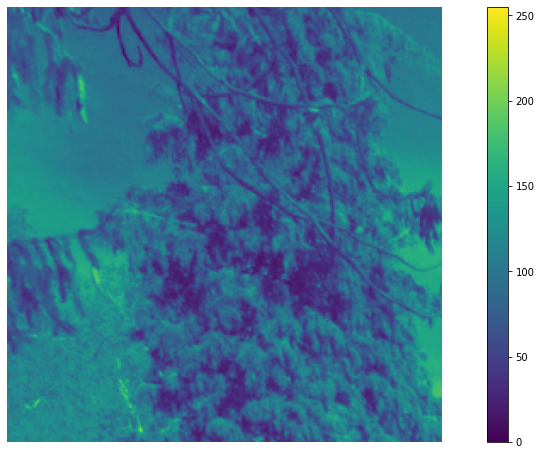

In [12]:
#R채널만 남기고 GB채널은 제거한 결과
##위의 분석을 통해 Stego image와 Cover image사이에 GB(초록과 파랑)은 차이가 없는 것을 확인하였다.
##이는 Stego image와 Cover image를 분류하는 데 있어 GB가 도움이 되지 않는다는 것을 의미하기에 제거해준다.
##본래 모델은 3채널의 이미지를 입력으로 받기 때문에, 추후에 모델 입력 채널을 1로 수정해줘야한다.
image = cv2.imread(os.path.join(TRAIN_DATA_ROOT_PATH, 'cover', '00001.png'), cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

## image[w,h,c]이므로, w와 h는 냅두고 c에서 0(red를 의미)만을 슬라이싱하여 다시 image에 대입한다.
## :은 본래 [시작:끝]이지만, '시작'과 '끝'을 생략하면 처음부터 끝까지를 의미하게 된다.(즉, w와 h는 모두 슬라이싱한다는 뜻)
image = image[:,:,0]

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

ax.set_axis_off()
im = ax.imshow(image, vmin=0, vmax=255)
fig.colorbar(im)
plt.show()

##추가 정보 : 슬라이싱(slicing):연속적인 객체들에(예: 리스트, 튜플, 문자열) 범위를 지정해 선택해서 객체들을 가져오는 방법 및 표기법을 의미합니다

## 홀수 채널만 남긴 이유

In [66]:
# Cover image를 기준으로, Stego Code가 적용되었을 때, 얼마나 변화하는지 확인하기 위한 과정 
pd.set_option('display.max_rows', None) ## 데이터프레임에서 모든 값을 출력하면 너무 많은 값을 출력하기 때문에 5개까지 출력하나, 정확하게 확인하기 위해서 제한을 해제한다.

cover_image = cv2.imread(os.path.join(TRAIN_DATA_ROOT_PATH, 'cover', '00001.png'), cv2.IMREAD_COLOR)
cover_image = cv2.cvtColor(cover_image, cv2.COLOR_BGR2RGB)
stego_image = cv2.imread(os.path.join(TRAIN_DATA_ROOT_PATH, 'stego', '00001.png'), cv2.IMREAD_COLOR)
stego_image = cv2.cvtColor(stego_image, cv2.COLOR_BGR2RGB)
##중요! 원래는 unit(0~255)이나, Stego Code가 음수인 경우를 제대로 확인하기 위해서 int(-255~255)으로 변경한다.
cover_image = cover_image[:,:,0].astype(np.int8) 
stego_image = stego_image[:,:,0].astype(np.int8)

##ndarray에 shape를 붙여주면, ndarray의 사이즈(3채널의 경우 w,h,c, 2채널의 경우 w, h)를 반환한다.
##언패킹을 통해서 [w,h]를 w, h에 각각 저장한다.(언패킹 : 여러 개의 데이터가 패킹된 것을 풀어서 각각의 다른 변수에 저장하는 것)
w, h = cover_image.shape
##differ(Cover image에서 stego code가 적용되었을 때, 변화값의 평균을 저장하는 리스트)
differ = np.zeros(256, dtype=np.int8) ##np.zeros는 인자로 크기를 받으며, 지정한 크기의 0으로 찬 ndarray을 반환한다.(ex.(2,3)을 주면 [[0,0][0,0][0,0]]을 성)

for i in range(0,w): ## 0~255을 i에 넣는 반복문(총 256번 반복)이며, 이미지의 W축을 한칸씩 이동한다.
    for j in range(0,h): ##0~255을 j에 넣는 반복문(총 256*256번 반복)이며, 이미지의 H축을 한칸씩 이동한다.
        temp = stego_image[i][j]-cover_image[i][j] ##stego code를 temp(임의변수를 의미)에 대입
        if differ[cover_image[i][j]]==0 : ##처음 계산된 값이라면 
            differ[cover_image[i][j]] = temp ##그대로 넣어준다(첫 계산인데 2를 나누면 값이 2배로 줄어듬)
        else : 
            differ[cover_image[i][j]] = (differ[stego_image[i][j]]+temp)/2 ##계산마다 더하고 2로 나눠 평균을 구한다.
frame = pd.DataFrame(differ, index = list(range(0,256))) 
frame
##최종적으로 나온 결과를 토대로, stego code는 -1또는 1인 것을 확인했다.
##추가로, Cover image의 짝수 비트에서는 stego code가 +1, 홀수 비트에서는 -1이 적용되는 것을 확인할 수 있다.

,0
0,0
1,0
2,1
3,0
4,0
5,-1
6,0
7,0
8,0
9,-1


In [ ]:
#지현 코드(짝수>홀수로 많이 갔는지, 홀수>짝수로 많이 갔는지 확인하는 코드)

##해당 결과를 통해 짝수>홀수로 간 것을 확인했고, 이는 Cover image에 비해 Stego image에 짝수 비트가 부족하다는 것을 알아낼 수 있다.

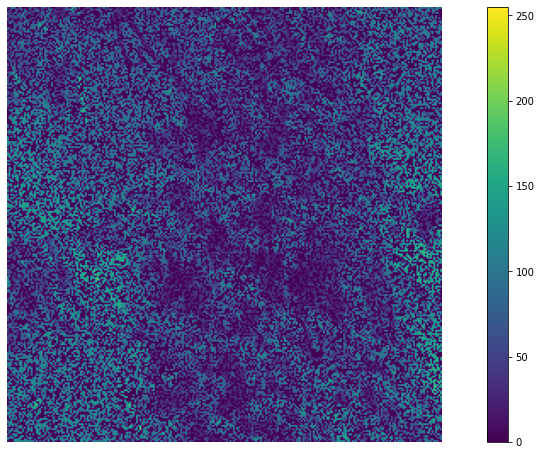

In [41]:
# 홀수 비트는 모두 제거하고, 짝수 비트만 남긴 결과
image = cv2.imread(os.path.join(TRAIN_DATA_ROOT_PATH, 'cover', '00001.png'), cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image[:,:,0]

##해당 분석에서 가장 중요한 코드로, 앞서 분석한 결과를 토대로 데이터 전처리를 수행하는 코드이다.
##Cover image에 비해 Stego image에는 홀수 비트의 수는 비슷하나 짝수 비트는 더 부족할 것이라는 것을 알아냈다.
##이를 통해 짝수 비트가 Stego image와 Cover image를 판별하는 중요 정보라는 것을 알아냈고, 홀수 비트는 모두 0으로 만든다.
temp = np.zeros((256,256), dtype = np.float32) ##0만 있는(검정색) 256x256 이미지
for j in range(0,255,2) : ##j에는 짝수만 들어간다.(0, 2, 4, 6...)
    index = np.where(j==image) ##image에서 짝수 비트인 픽셀의 x, y좌표를 알아내고
    temp[index] = image[index] ##해당 이미지의 픽셀(x,y)을 temp의 픽셀(x,y)에 반영한다. 
image = temp ##최종적으로 계산이 끝났다면, temp를 image로 만든다.

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

ax.set_axis_off()
im = ax.imshow(image, vmin=0, vmax=255)
fig.colorbar(im)
plt.show()

# Dataset

In [134]:
class DatasetRetriever(Dataset):
    def __init__(self, kinds, image_names, labels, transforms=None):
        super().__init__()
        self.kinds = kinds
        self.image_names = image_names
        self.labels = labels
        self.transforms = transforms

    def __getitem__(self, index: int):
        kind, image_name, label = self.kinds[index], self.image_names[index], self.labels[index]
        image_path = f'{TRAIN_DATA_ROOT_PATH}/{kind}/{image_name}'.replace('\\', '/')
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image = image[:,:,0]

        temp = np.zeros((256,256), dtype = np.float32)
        for j in range(0,255,2) : 
            index = np.where(j==image)
            temp[index] = image[index]
        image = temp
#         for i in range(256):
#             for j in range(256):
#                 if (image[i][j]%2)!=0:
#                     image[i][j] = 0

        image /= 255.0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
            
        return image, label

    def __len__(self) -> int:
        return self.image_names.shape[0]

    def get_labels(self):
        return list(self.labels)

# Simple Augmentations: Flips

In [135]:
def get_train_transforms():
    return A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            ToTensorV2(p=1.0),
        ], p=1.0)

def get_valid_transforms():
    return A.Compose([
            ToTensorV2(p=1.0),
        ], p=1.0)

In [136]:
train_dataset = DatasetRetriever(
    kinds=dataset[dataset['fold'] != args['val_fold']].kind.values,
    image_names=dataset[dataset['fold'] != args['val_fold']].image_name.values,
    labels=dataset[dataset['fold'] != args['val_fold']].label.values,
    transforms=get_train_transforms(),
)

validation_dataset = DatasetRetriever(
    kinds=dataset[dataset['fold'] == args['val_fold']].kind.values,
    image_names=dataset[dataset['fold'] == args['val_fold']].image_name.values,
    labels=dataset[dataset['fold'] == args['val_fold']].label.values,
    transforms=get_valid_transforms(),
)

1


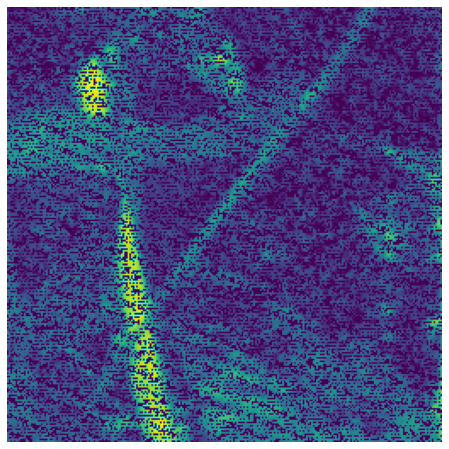

In [137]:
image, target = train_dataset[2]
numpy_image = image.permute(1,2,0).cpu().numpy()
print(target)
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

ax.set_axis_off()
ax.imshow(numpy_image)

In [138]:
train_loader = torch.utils.data.DataLoader(
        train_dataset,
        sampler=BalanceClassSampler(labels=train_dataset.get_labels(), mode="downsampling"),
        batch_size=args['batch_size'],
        pin_memory=False,
        drop_last=True,
    )
val_loader = torch.utils.data.DataLoader(
        validation_dataset,
        batch_size=args['batch_size'],
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
    )

# Metrics

In [139]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, label, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = label.size(0)

    _, pred = output.topk(maxk, 1, True, True)  # prediction: select k maximum at each output
    pred = pred.t()
    correct = pred.eq(label.view(1, -1).expand_as(pred))
    acc = correct.view(-1).float().sum(0, keepdim=True).mul_(100.0 / batch_size)  # acc = num of equivalcencs / target_size
    result = to_np(correct.view(-1))

    return acc, result

def to_np(x):
    return x.detach().cpu().data.numpy()

# Loss

In [140]:
loss_func = nn.CrossEntropyLoss().to(device)

# Model

In [141]:
!mkdir './checkpoints'
def get_net():
#     net = timm.create_model(args['model_name'], num_classes=args['num_classes'], pretrained=True)
    net = timm.create_model(args['model_name'], in_chans=1, num_classes=args['num_classes'], pretrained=True)
#     net.in_channels = 1
    return net

model = get_net().to(device)

mkdir: cannot create directory ‘./checkpoints’: File exists


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_ns-c0e6a31c.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_ns-c0e6a31c.pth


# Save & Load pretrained model

In [142]:
def save_checkpoint(model, optimizer, best_acc, checkpoint_path, model_name, is_best, epoch):
    state = {
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'best_acc': best_acc,
        'epoch': epoch
    }

    if not os.path.exists(checkpoint_path):
        os.makedirs(checkpoint_path)

    filename = os.path.join(checkpoint_path, f'{model_name}_model_epoch_{state["epoch"]}.pth')
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, os.path.join(checkpoint_path, f'{model_name}_model_best.pth'))


def load_checkpoint(model, optimizer, pretrained_path, device):
    state = torch.load(pretrained_path, map_location=device)
    model.load_state_dict(state['model'])
    best_acc = state['best_acc']
    epoch = state['epoch']
    print(f'\t## loaded trained models (epoch: {epoch})\n')
    return model, optimizer, best_acc, epoch

# Optimizer

In [143]:
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=args['lr'], betas=(0.9, 0.999),
                              weight_decay=args['weight_decay'])

# Load pretrained model

In [144]:
# if args['pretrained_name']:
#     pretrained_path = os.path.join(args['checkpoint_dir'], args['pretrained_name'])
#     model, optimizer, best_acc, initial_epoch = load_checkpoint(model, optimizer, pretrained_path, device)
# else:
#     initial_epoch = 0
#     best_acc = 0
initial_epoch = 0
best_acc = 0

# Train

In [145]:
def train(train_loader, model, *args):
    # switch to train mode
    model.train()

    with torch.enable_grad():
        train_acc, train_loss = iteration('train', train_loader, model, *args)

    return train_acc, train_loss

# Validate

In [146]:
def validate(val_loader, model, *args):
    # switch to eval mode
    model.eval()

    with torch.no_grad():
        val_acc, val_loss = iteration('val', val_loader, model, *args)

    return val_acc, val_loss

# Iteration

In [147]:
def iteration(mode, data_loader, model, optimizer, loss_func, epoch):
    am_batch_time = AverageMeter()
    am_data_time = AverageMeter()
    am_loss = AverageMeter()
    am_acc = AverageMeter()

    end = time.time()
    num_batch = np.ceil(len(data_loader)).astype(np.int32)

    for i, (input_img, target) in enumerate(data_loader):
        # measure data loading time
        am_data_time.update(time.time() - end)

        input_img = input_img.to(device)
        target = target.to(device)

        # feed-forward
        output = model(input_img)   # two output

        # calculate loss
        output = torch.nan_to_num(output)
        loss = loss_func(output, target)
        am_loss.update(loss.item(), input_img.size(0))

        # calculate accuracy
        class_prob = F.softmax(output, dim=1)
        class_acc, _ = accuracy(class_prob, target)
        am_acc.update(class_acc.item(), input_img.size(0))

        # compute gradient and do SGD step
        if mode == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # measure elapsed time
        am_batch_time.update(time.time() - end)
        end = time.time()
        if (i + 1) % args['log_step'] == 0:
            print('Epoch: [{0}/{1}][{2}/{3}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f}) \t'
                  'Accuracy {acc.val:.4f} ({acc.avg:.4f})'
                  .format(epoch + 1, args['num_epochs'], i + 1, num_batch, batch_time=am_batch_time,
                          data_time=am_data_time, loss=am_loss, acc=am_acc))

    return am_acc.avg, am_loss.avg

# Pipeline: train, validate, log, and save

In [ ]:
# wandb.run.name = 'steganalysis(classification, gb remove, b6)'
min_loss = 1000
for epoch in range(initial_epoch, args['num_epochs']):
    # train for one epoch
    print('# Training')
    train_acc, train_loss = train(train_loader, model, optimizer, loss_func, epoch)
#     wandb.log({'train_acc': train_acc, 'train_loss': train_loss})

    # evaluate on validation set
    print('# Validation')
    val_acc, val_loss = validate(val_loader, model, optimizer, loss_func, epoch)
#     wandb.log({'val_acc': val_acc, 'val_loss':val_loss})

    is_best = val_acc > best_acc
    best_acc = max(val_acc, best_acc)
    min_loss = min(val_loss, min_loss)

    if is_best or (epoch + 1) % args['model_save_step'] == 0:
        save_checkpoint(model, optimizer, best_acc, args['checkpoint_dir'], args['model_name'], is_best, epoch + 1)

# Training
Epoch: [1/10][50/281]	Time 2.806 (2.580)	Data 2.514 (2.290)	Loss 0.0272 (0.1082) 	Accuracy 98.4375 (97.6562)
Epoch: [1/10][100/281]	Time 3.292 (2.563)	Data 3.000 (2.273)	Loss 0.0000 (0.0619) 	Accuracy 100.0000 (98.6250)
Epoch: [1/10][150/281]	Time 2.842 (2.557)	Data 2.554 (2.267)	Loss 0.1850 (0.0439) 	Accuracy 96.8750 (99.0417)
Epoch: [1/10][200/281]	Time 3.312 (2.546)	Data 3.019 (2.257)	Loss 0.0063 (0.0375) 	Accuracy 100.0000 (99.1875)
Epoch: [1/10][250/281]	Time 2.453 (2.534)	Data 2.165 (2.245)	Loss 0.0000 (0.0318) 	Accuracy 100.0000 (99.3000)
# Validation
# Training
Epoch: [2/10][50/281]	Time 2.489 (2.523)	Data 2.202 (2.234)	Loss 0.0000 (0.0008) 	Accuracy 100.0000 (99.9375)
Epoch: [2/10][100/281]	Time 2.460 (2.546)	Data 2.172 (2.257)	Loss 0.0000 (0.0009) 	Accuracy 100.0000 (99.9375)
Epoch: [2/10][150/281]	Time 2.620 (2.544)	Data 2.332 (2.255)	Loss 0.0000 (0.0047) 	Accuracy 100.0000 (99.8750)
Epoch: [2/10][200/281]	Time 2.598 (2.548)	Data 2.310 (2.259)	Loss 0.0143 (0.0040)

In [173]:
# !zip -r output_b4.zip checkpoints/

# Inference

In [100]:
pretrained_path = os.path.join(args['checkpoint_dir'], args['pretrained_name'])
model, _, _, _ = load_checkpoint(model, optimizer, pretrained_path, device)
model.eval()

	## loaded trained models (epoch: 2)



EfficientNet(
  (conv_stem): Conv2dSame(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=

In [103]:
class DatasetSubmissionRetriever(Dataset):
    def __init__(self, image_names, transforms=None):
        super().__init__()
        self.image_names = image_names
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_name = self.image_names[index]
        image_path = f'{TEST_DATA_ROOT_PATH}/{image_name}'
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image = image[:,:,0]


        temp = np.zeros((256,256), dtype = np.float32)
        for j in range(0,255,2) : 
            index = np.where(j==image)
            temp[index] = image[index]
        image = temp
        
        image /= 255.0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']

        return image_name, image

    def __len__(self) -> int:
        return self.image_names.shape[0]

In [104]:
dataset = DatasetSubmissionRetriever(
    image_names=np.array([path.replace('\\', '/').split('/')[-1] for path in glob(f'{TEST_DATA_ROOT_PATH}/*.png')]),
    transforms=get_valid_transforms(),
)


test_loader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=False,
    drop_last=False,
)

In [105]:
df_result = pd.DataFrame(columns=['id', 'label'])
for step, (image_names, images) in enumerate(test_loader):
    print(step, end='\r')
    images = images.to(device)
    output = model(images)
    class_prob = F.softmax(output, dim=1)
    _, class_pred = output.topk(1, 1, True, True)  # prediction: select k maximum at each output
    label = class_pred.view(-1).detach().cpu().numpy()
    df_curr = pd.DataFrame({
        'id': image_names,
        'label': label
    })
    df_result = pd.concat([df_result, df_curr], axis=0, ignore_index=True)

In [107]:
current_time = datetime.now().strftime(r'%y-%m-%d_%H-%M-%S')
df_result.to_csv(f'remove_odd.csv', index=False)
df_result.head()

,id,label
0,11396.png,1
1,10760.png,1
2,10188.png,0
3,11953.png,1
4,11572.png,1
